# Keylogger Detection

## Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

## Data Preparation

In [4]:
df=pd.read_csv('system_info_compiled.csv')
df.head()

,Hostname,IP Address,OS,Running Processes,Running Threads,Time,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Errors In,Errors Out,Dropped Packets In,Dropped Packets Out,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min
0,HP-Pavilion,192.168.56.1,Windows,"System Idle Process, System, , Registry, smss....",1,1679690719,86406,190527,12314705,255705103,0,0,0,0,34451,65535,119,12140931,11914164,19
1,HP-Pavilion,192.168.56.1,Windows,"System Idle Process, System, , Registry, smss....",1,1679690750,86501,190634,12359926,255730342,0,0,0,0,53892,65535,175,418882,76788,4
2,HP-Pavilion,192.168.56.1,Windows,"System Idle Process, System, , Registry, smss....",1,1679690781,86637,190773,12396520,255779742,0,0,0,0,443,179,-1,45,45,45
3,HP-Pavilion,192.168.56.1,Windows,"System Idle Process, System, , Registry, smss....",1,1679690812,86751,190894,12432712,255818545,0,0,0,0,23025,-1,-1,541699,541699,541699
4,HP-Pavilion,192.168.56.1,Windows,"System Idle Process, System, , Registry, smss....",1,1679690905,88092,193793,12739826,259500003,0,0,0,0,52602,1552,-1,7310795,7280174,30621


In [5]:
df.shape

(144, 20)

### Dropping Unnecessary Columns

In [6]:
df.drop(['Hostname','IP Address', 'OS', 'Time'],axis=1,inplace=True)
df.head()

,Running Processes,Running Threads,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Errors In,Errors Out,Dropped Packets In,Dropped Packets Out,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min
0,"System Idle Process, System, , Registry, smss....",1,86406,190527,12314705,255705103,0,0,0,0,34451,65535,119,12140931,11914164,19
1,"System Idle Process, System, , Registry, smss....",1,86501,190634,12359926,255730342,0,0,0,0,53892,65535,175,418882,76788,4
2,"System Idle Process, System, , Registry, smss....",1,86637,190773,12396520,255779742,0,0,0,0,443,179,-1,45,45,45
3,"System Idle Process, System, , Registry, smss....",1,86751,190894,12432712,255818545,0,0,0,0,23025,-1,-1,541699,541699,541699
4,"System Idle Process, System, , Registry, smss....",1,88092,193793,12739826,259500003,0,0,0,0,52602,1552,-1,7310795,7280174,30621


In [7]:
for col in (df.iloc[:,:-1].columns):
    if(df[col].min()==df[col].max()):
            df.drop(col, axis=1, inplace=True)

In [8]:
df.head()

,Running Processes,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min
0,"System Idle Process, System, , Registry, smss....",86406,190527,12314705,255705103,34451,65535,119,12140931,11914164,19
1,"System Idle Process, System, , Registry, smss....",86501,190634,12359926,255730342,53892,65535,175,418882,76788,4
2,"System Idle Process, System, , Registry, smss....",86637,190773,12396520,255779742,443,179,-1,45,45,45
3,"System Idle Process, System, , Registry, smss....",86751,190894,12432712,255818545,23025,-1,-1,541699,541699,541699
4,"System Idle Process, System, , Registry, smss....",88092,193793,12739826,259500003,52602,1552,-1,7310795,7280174,30621


### Creating labels for the data set.

Check if 'keylogger.exe' is present in the list of processes. if it is present, then it is a keylogger and if not, then it is not a keylogger.

In [9]:
df['keylogger']=df['Running Processes'].apply(lambda x: 1 if 'keylogger.exe' in x else 0)
df.head()

,Running Processes,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min,keylogger
0,"System Idle Process, System, , Registry, smss....",86406,190527,12314705,255705103,34451,65535,119,12140931,11914164,19,1
1,"System Idle Process, System, , Registry, smss....",86501,190634,12359926,255730342,53892,65535,175,418882,76788,4,0
2,"System Idle Process, System, , Registry, smss....",86637,190773,12396520,255779742,443,179,-1,45,45,45,1
3,"System Idle Process, System, , Registry, smss....",86751,190894,12432712,255818545,23025,-1,-1,541699,541699,541699,0
4,"System Idle Process, System, , Registry, smss....",88092,193793,12739826,259500003,52602,1552,-1,7310795,7280174,30621,0


Replacing the 'Running Processes' column with length of each process list


In [10]:
df['Running Processes']=df['Running Processes'].apply(lambda x: len(x.split(',')))
df.head()

,Running Processes,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min,keylogger
0,274,86406,190527,12314705,255705103,34451,65535,119,12140931,11914164,19,1
1,273,86501,190634,12359926,255730342,53892,65535,175,418882,76788,4,0
2,274,86637,190773,12396520,255779742,443,179,-1,45,45,45,1
3,278,86751,190894,12432712,255818545,23025,-1,-1,541699,541699,541699,0
4,277,88092,193793,12739826,259500003,52602,1552,-1,7310795,7280174,30621,0


In [11]:
df.describe()

,Running Processes,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min,keylogger
count,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,144.000000,144.000000,144.000000,1.440000e+02,1.440000e+02,1.440000e+02,144.000000
mean,278.493056,229314.798611,6.394986e+05,2.746119e+07,5.111299e+08,37152.305556,21958.402778,1400.034722,1.027727e+07,8.883376e+06,1.459479e+06,0.159722
std,20.550465,175044.110401,5.478894e+05,1.984356e+07,4.058441e+08,19384.017342,30104.769814,6337.795256,1.996911e+07,1.647598e+07,5.575625e+06,0.367627
min,244.000000,34816.000000,5.585900e+04,4.143578e+06,5.503617e+07,0.000000,-1.000000,-1.000000,1.500000e+01,1.500000e+01,-2.000000e+00,0.000000
25%,255.000000,43296.500000,7.015550e+04,6.156874e+06,6.400346e+07,33375.750000,180.500000,-1.000000,4.583750e+04,4.103975e+04,3.925000e+01,0.000000
50%,281.000000,278807.500000,8.486840e+05,4.065604e+07,6.418496e+08,43466.000000,1615.000000,15.500000,4.176385e+05,2.789685e+05,8.224500e+03,0.000000
75%,298.000000,419941.750000,1.107593e+06,4.216844e+07,9.205276e+08,50221.750000,65535.000000,387.250000,1.211525e+07,1.095558e+07,1.107782e+05,0.000000
max,304.000000,435362.000000,1.484075e+06,5.504423e+07,1.006200e+09,61032.000000,65535.000000,65535.000000,1.121280e+08,9.057448e+07,4.239845e+07,1.000000


In [12]:
df.groupby('keylogger').size()

keylogger
0    121
1     23
dtype: int64

## SMOTE

In [13]:
# Perform SMOTE to balance the dataset
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(df.iloc[:,:-1], df.iloc[:,-1])
df = pd.concat([X, y], axis=1)
df.head()

,Running Processes,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min,keylogger
0,274,86406,190527,12314705,255705103,34451,65535,119,12140931,11914164,19,1
1,273,86501,190634,12359926,255730342,53892,65535,175,418882,76788,4,0
2,274,86637,190773,12396520,255779742,443,179,-1,45,45,45,1
3,278,86751,190894,12432712,255818545,23025,-1,-1,541699,541699,541699,0
4,277,88092,193793,12739826,259500003,52602,1552,-1,7310795,7280174,30621,0


In [14]:
df.groupby('keylogger').size()

keylogger
0    121
1    121
dtype: int64

## Correlation Matrix

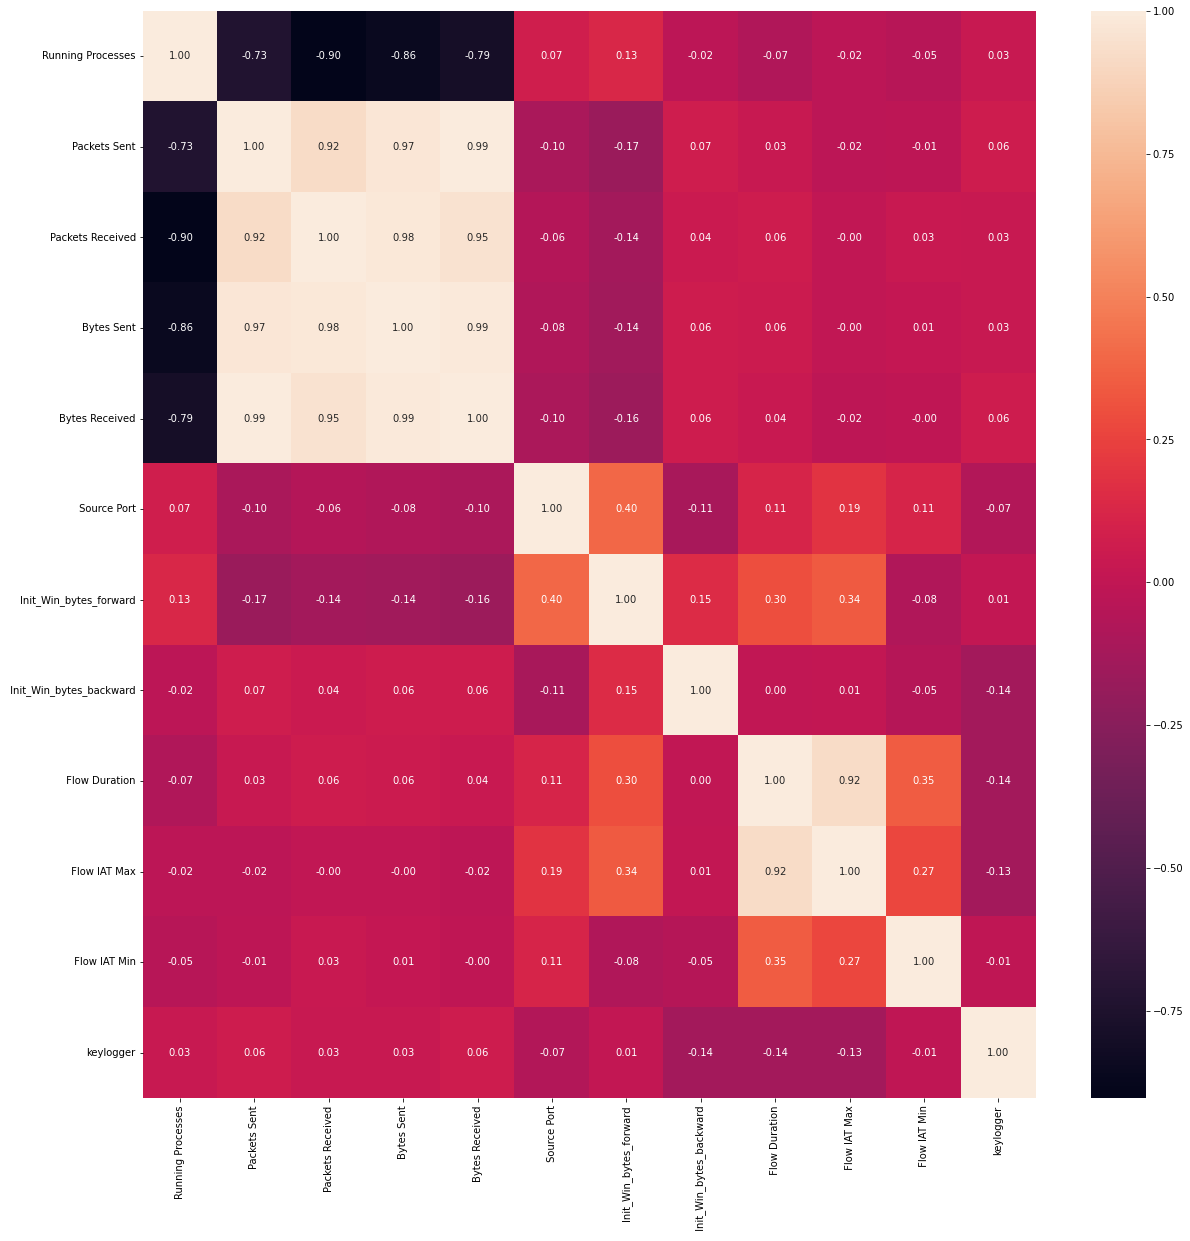

In [15]:
corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

## Feature Scaling

In [16]:
# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df.iloc[:,:-1])
scaled_features = scaler.transform(df.iloc[:,:-1])
df_feat = pd.DataFrame(scaled_features,columns=df.iloc[:,:-1].columns)
df_feat.head()


,Running Processes,Packets Sent,Packets Received,Bytes Sent,Bytes Received,Source Port,Init_Win_bytes_forward,Init_Win_bytes_backward,Flow Duration,Flow IAT Max,Flow IAT Min
0,-0.265036,-0.842706,-0.834371,-0.778840,-0.658207,-0.111659,1.503005,-0.167715,0.217910,0.326587,-0.291741
1,-0.315980,-0.842170,-0.834174,-0.776555,-0.658145,0.983707,1.503005,-0.156311,-0.501956,-0.546124,-0.291744
2,-0.265036,-0.841402,-0.833918,-0.774706,-0.658025,-2.027774,-0.780951,-0.192151,-0.527678,-0.551782,-0.291735
3,-0.061259,-0.840759,-0.833695,-0.772878,-0.657930,-0.755435,-0.787241,-0.192151,-0.494414,-0.511849,-0.178068
4,-0.112204,-0.833192,-0.828355,-0.757363,-0.648936,0.911024,-0.732969,-0.192151,-0.078715,-0.015054,-0.285319


## Splitting the dataset into the Training set and Test set

In [17]:
# perform train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['keylogger'],test_size=0.30)

## Building the model

In [18]:
target=['keylogger']
features = [c for c in df.columns if c!="keylogger"]

lgb_train = lgb.Dataset(X_train, y_train,feature_name=features)
lgb_valid = lgb.Dataset(X_test, y_test,feature_name=features)

params= {
        'objective': 'binary',
        'metric': 'auc',
        'seed': 42,
        'learning_rate': 0.05,
        'max_bin': 850,
        'num_leaves': 70
        }

model_lgb = lgb.train(params, 
                  lgb_train,
                  valid_sets=[lgb_train, lgb_valid],
                  verbose_eval=100,
                  num_boost_round=10000,
                  early_stopping_rounds=10
                )

c:\Users\Aviral.HP-PAVILION\anaconda3\envs\Deep learning\lib\site-packages\lightgbm\engine.py:181: UserWarning:

'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

c:\Users\Aviral.HP-PAVILION\anaconda3\envs\Deep learning\lib\site-packages\lightgbm\engine.py:239: UserWarning:

'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 84, number of negative: 85
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 563
[LightGBM] [Info] Number of data points in the train set: 169, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497041 -> initscore=-0.011834
[LightGBM] [Info] Start training from score -0.011834
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

In [19]:
y_pred = model_lgb.predict(X_test)
AUC = metrics.roc_auc_score(y_test,y_pred)
print("AUC: {:.3f}".format(AUC))

AUC: 0.949


## Saving the Model

In [20]:
# pickling the model
import pickle
filename = 'keylogger_model.pkl'
pickle.dump(model_lgb, open(filename, 'wb'))

# pickling the scaler
filename = 'keylogger_scaler.pkl'
pickle.dump(scaler, open(filename, 'wb'))